<a href="https://colab.research.google.com/github/Stefi99R/PPPO_IT42-2018/blob/master/SegmentacijaSoli_IT42_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Univerzitet u Novom Sadu**

**Fakultet tehničkih nauka**

**Departman za industrijsko inženjerstvo i menadžment**

**Inženjerstvo informacionih sistema**

**Predmet:** Principi prezentacije i prepoznavanja oblika

**Tema:** Segmentacija fotografije

**Student:** Stefan Radojević IT42/2018

# Teorijski uvod

Cilj izrade ovog zadatka je kreiranje modela koji bi predstavio način funkcionisanja procesa segmentacije. Kako bi tema bila obrađena na pravi način, predstavljena je kroz teorijski i praktični deo, pri čemu teorijski deo obuhvata osnovne informacije o segmentaciji fotografija, dok se u praktičnom delu vrši analiza, kreiranje modela i validacija kreiranog modela nad određenim skupovima podataka.

U okviru projekta korišćena je *U-Net* konvoluciona neuronska mreža koja obezbeđuje brzu i preciznu semantičku segmentaciju slika. Njena arhitektura može se posmatrati kao mreža enkodera koju prati mreža dekodera. Za razliku od klasifikacije gde je krajnji rezultat mreže jedina važna stvar, semantička segmentacija ne zahteva samo diskriminaciju na nivou piksela već i mehanizam za projektovanje diskriminativnih karakteristika naučenih u različitim fazama enkodera na prostor piksela.

## O segmentaciji

Segmentacija fotografije je proces podele digitalne fotografije na više segmenata (skupova piksela) odnosno različitih regiona ili kategorija, pri čemu svaka regija sadrži piksele sa sličnim atributima, a svaki piksel na fotografiji dodeljuje se jednoj od ovih kategorija. Segmentacija fotografije je zapravo postupak dodeljivanja oznake svakom pikselu na fotografiji tako da pikseli sa istom oznakom dele određene karakteristike. 

Segmentacija se obično koristi za lociranje objekata i granica (linija, ivica, itd.) na fotografijama.

## Vrste segmentacije

Iako se u literaturi često pominje više vrsta na segmentacije, osnovna podela obuhvata dve kategorije, i to:

*   **semantička segmentacija** (izdvajanje regiona), tehnika zasnovana na izdvajanju celog objekta od pozadine povezujući piksele čija je svetlost ispod nekog praga pozadini, dok se ostatak pridružuje objektu, ili obrnuto,
*   **segmentacija instance** (pronalaženje ivica), tehnika koja je zasnovana na izdvajanju samo onih piksela koji se nalaze u ivicama objekta.

Kako obe ove vrste segmentacije izgledaju, predstavljeno je na sledećoj slici.

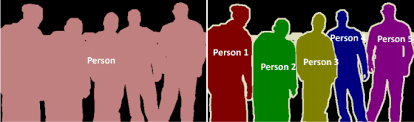

## Algoritmi i tehnike segmentacije

Postoje različite podele algoritama i tehnika za segmentaciju u zavisnosti od autora ali najveći broj njih se svodi na sledeće 4:

1.   **Segmentacija pragom (eng. *Thresholding*)** - grupa metoda zasnovanih na poređenju osvetljenosti piksela sa jednim ili više pragova, pa tako imamo segmentaciju sa jednim i segmentaciju sa više pragova. Ukoliko imamo slike u boji tada se vrši poređenje boje između piksela. 
2.   **Segmentacija klasterizacijom (eng. *Clustering*)** - primenjivana u segmentaciji multispektralnih satelitskih ili avionskih snimaka, gdje je osnovni cilj bio izdvajanje regiona na površini zemlje koji imaju iste karakteristike, kao što su npr., isti tip poljoprivrednih kultura, isti sastav zemljišta, ista nadmorska visina, itd. Nedostatak ove metode je što ima veliku računsku složenost.
3.   **Segmentacija regionom (eng. *Region*)** - predstavlja skup metoda koje pokušavaju da izdvoje područja slike koja su homogena sa gledišta određenih karakteristika.
4.   **Segmentacija granicom regiona (eng. *Edge*)** - zahteva da se primeni i neki postupak za spajanje ivica, kako bi se formirale neprekidne granice regiona iz razloga što metode koje vrše izdvajanje ivica generišu isprekidane granice objekata a ne zatvorene krive. Glavna prednost ovog metoda je njena izuzetna jednostavnost i ona daje dobre rezultate u slučaju segmentacije jednostavnih scena. Međutim, kada imamo slike na kojima postoji veći broj objekata koji se preklapaju, mapa ivica sadrži tačke grananja, pa u tom slučaju ova metoda ne daje dobre rezultate.


## Skup podataka

Skup podataka korišćen za izradu ovog zadatka predstavlja skup satelitskih snimaka raznih regiona planete Zemlje. Dati skup je korišćen za kreiranje modela koji bi vršio segmentaciju slika kako bi detektovao površine koje predstavljaju nalazišta soli, i time svaku sliku podelio na deo koji sadrži so, i onaj koji je ne sadrži.

Skup se sastoji od dva bitna dela, pri čemu jedan predstavlja skup za trening modela, dok drugi predstavlja skup podataka korišćen za validaciju/testiranje modela. Testni skup podataka se sastoji od dve celine, pri čemu prva predstavlja satelitske snimke Zemlje, dok drugi predstavlja maske, odnosno fotografije koje mogu biti korišćene za trening modela za segmentaciju  lokacija soli.

Skup podataka korišćen za izradu ovog zadatka je moguće preuzeti putem datog [linka](https://drive.google.com/file/d/1y3S7yfpdrR_MutnotPAR8OnNqRX3POVF/view?usp=sharing).

# Učitavanje potrebnih biblioteka

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from random import *
import os
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import tensorflow as tf

Proveravamo da li je u upotrebi TPU/GPU, radi bržeg treniranja modela

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Preuzimanje i ekstrahovanje podataka

U prvom koraku implementacije ovog rešenja, podaci su preuzeti sa odgovarajućeg Google Drive-a, a potom ekstrahovani, radi njihove analize i manipulacije nad njima.

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!gdown https://drive.google.com/uc?id=1y3S7yfpdrR_MutnotPAR8OnNqRX3POVF

Downloading...
From: https://drive.google.com/uc?id=1y3S7yfpdrR_MutnotPAR8OnNqRX3POVF
To: /content/#5.zip
100% 466M/466M [00:05<00:00, 79.5MB/s]


In [5]:
!unzip '#5.zip'

Archive:  #5.zip
  inflating: competition_data.zip    
  inflating: depths.csv              
  inflating: flamingo.zip            
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


**Napomena:** Komanda `&> /dev/null` će sakriti izlaz `unzip` operacije, kako se u _output_-u ne bi prikazali nazivi svih slika u zipovanom folderu, i time smanjila vidljivost rešenja. 

**Napomena 2:** U slučaju da se izvršavanje koda zaustavi na ovom koraku, možda je potrebno uneti slovo `A` ili `y`, pošto je prava naredba koja će pregaziti prethodne podatke sakrivena kao rezultat `&> /dev/null` komande.

In [6]:
!unzip train.zip &> /dev/null 

# Analiza podataka

Radi boljeg razumevanja podataka, u narednom koraku će ukratko biti opisano.

In [7]:
TRAIN_IMAGE_DIR = '/content/images'
TRAIN_MASK_DIR = '/content/masks'

train_d = os.listdir(TRAIN_IMAGE_DIR)

Radi lakšeg procesuiranja, izvršena je normalizacija piksela po fotografijama, čime su sve vrednosti prikazane u rasponu od 0 do 1.

In [8]:
x = [np.array(cv2.imread(TRAIN_IMAGE_DIR + "/{}".format(p), cv2.IMREAD_GRAYSCALE)) for p in train_d]
x = np.array(x) / 255

y = [np.array(cv2.imread(TRAIN_MASK_DIR + "/{}".format(p), cv2.IMREAD_GRAYSCALE)) for p in train_d]
y = np.array(y) / 255

print(x.shape, y.shape)

(4000, 101, 101) (4000, 101, 101)


Funkcijom datom u nastavku se prikazuju nasumicno odabrane fotografije, zajedno sa maskama koje su označene crvenom bojom.

In [9]:
def plotImages(file1, file2, k, alpha = 0.4):
  fig, ax = plt.subplots(nrows = k, ncols = k, figsize = (15, 15))
  for i in range(k):
    for j in range(k):
      ind = randint(0, file1.shape[0] - 1)
      ax[i, j].imshow(file1[ind], cmap = 'Greys')
      ax[i, j].imshow(file2[ind], cmap = 'Reds', alpha = alpha)
      ax[i, j].set_axis_off()
  fig.subplots_adjust(wspace = -0.30, hspace= 0.05)
  return(fig)

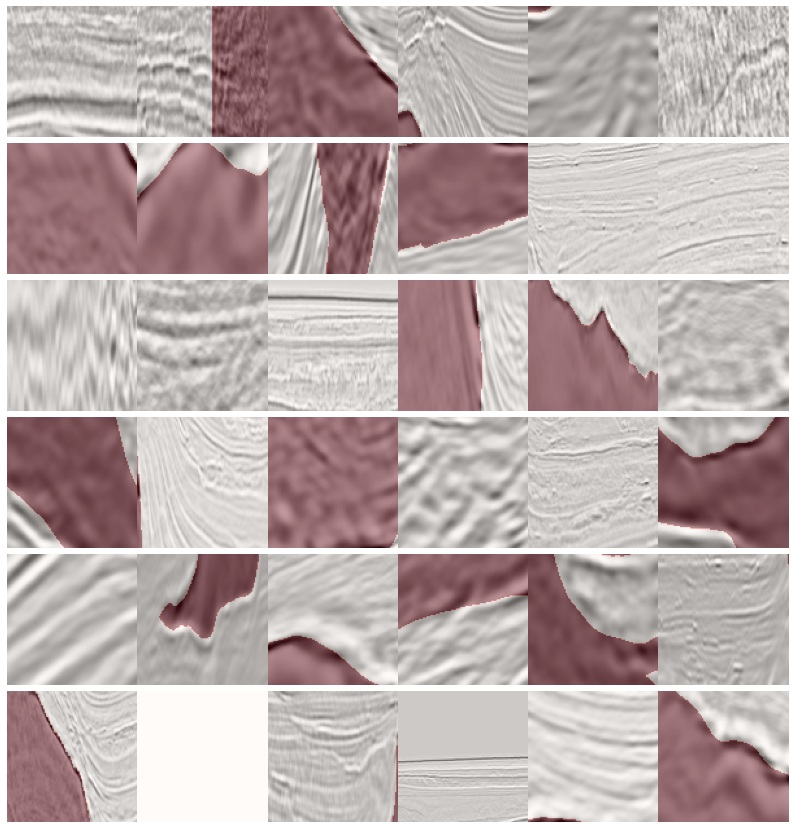

In [10]:
fig = plotImages(x, y, k = 6)

Razmera trening-validacionog skupa podataka je 80:20, tj. 80% pripada trening skupu, dok validacionom pripada 20% podataka.

In [11]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 50)

In [12]:
print("x_train shape:", x_train.shape)
print("x_validation shape:", x_validation.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_validation.shape)

x_train shape: (3200, 101, 101)
x_validation shape: (800, 101, 101)
y_train shape: (3200, 101, 101)
y_validation shape: (800, 101, 101)


# Kreiranje modela

Nakon što su podaci opisani, na osnovu njih se kreira model za segmentaciju soli.

Kreirani model prati U-Net arhitekturu konvolucijske mreže, koja se sastoji od contracting i expanding putanje, gde se kod prve prati tipična arhitektura konvolucione mreže, a kod druge se radi upsampling mape obeležja, praćenih 2x2 konvolucijom („up-convolution“) koja prepolovljava broj kanala, spajanja sa odgovarajućom isečenom mapom obeležja sa contracting putanje i dve 3x3 konvolucije, nakon kojih sledi ReLU.

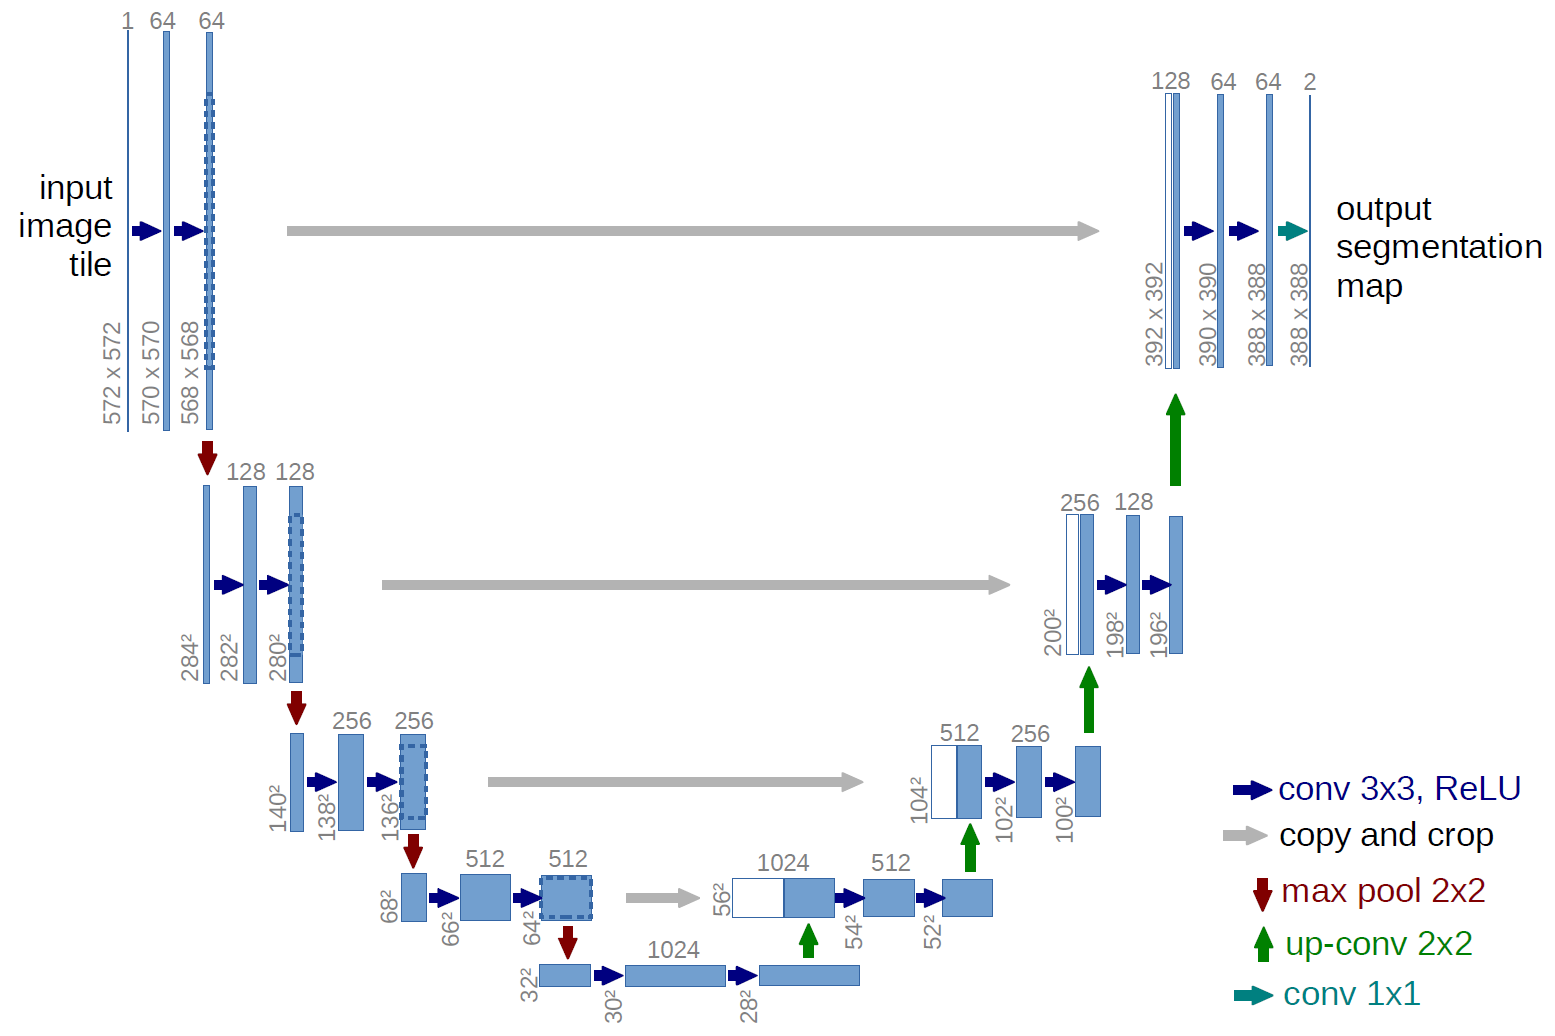

Prilikom definisanja modela kombinuju se konvolucioni i residual blokovi kako bi se izgradila ResNet mreža.

In [13]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides = (1, 1), padding = 'same', activation = True):
    x = Conv2D(filters, size, strides = strides, padding = padding)(x)
    if activation == True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters = 16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation = False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [14]:
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation = None, padding = 'same')(input_layer)
    conv1 = residual_block(conv1, start_neurons * 1)
    conv1 = residual_block(conv1, start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio / 2)(pool1)
    print("conv1", conv1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation = None, padding = 'same')(pool1)
    conv2 = residual_block(conv2, start_neurons * 2)
    conv2 = residual_block(conv2, start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    print("conv2", conv2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation = None, padding = 'same')(pool2)
    conv3 = residual_block(conv3, start_neurons * 4)
    conv3 = residual_block(conv3, start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    print("conv3", conv3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation = None, padding = 'same')(pool3)
    conv4 = residual_block(conv4, start_neurons * 8)
    conv4 = residual_block(conv4, start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    print("conv4", conv4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation = None, padding = 'same')(pool4)
    convm = residual_block(convm, start_neurons * 16)
    convm = residual_block(convm, start_neurons * 16, True)
    print("convm", convm)

    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides = (2, 2), padding = 'same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation = None, padding = 'same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons * 8)
    uconv4 = residual_block(uconv4, start_neurons * 8, True)
    print("conv4", uconv4)

    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides = (2, 2), padding = 'valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation = None, padding = 'same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons * 4)
    uconv3 = residual_block(uconv3, start_neurons * 4, True)
    print("conv3", uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding = 'same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation = None, padding = 'same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons * 2)
    uconv2 = residual_block(uconv2, start_neurons * 2, True)
    print("conv2", uconv2)

    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding = 'valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation = None, padding = 'same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons * 1)
    uconv1 = residual_block(uconv1, start_neurons * 1, True)
    
    output_layer_noActi = Conv2D(1, (1, 1), padding = 'same', activation = None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

U nastavku je dat detaljan opis svakog sloja novokreirane mreže.

In [15]:
input_layer = Input((101, 101, 1))
output_layer = build_model(input_layer, 32, 0.5)

model = Model(input_layer, output_layer)
model.summary()

conv1 KerasTensor(type_spec=TensorSpec(shape=(None, 101, 101, 32), dtype=tf.float32, name=None), name='activation_4/Relu:0', description="created by layer 'activation_4'")
conv2 KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 64), dtype=tf.float32, name=None), name='activation_9/Relu:0', description="created by layer 'activation_9'")
conv3 KerasTensor(type_spec=TensorSpec(shape=(None, 25, 25, 128), dtype=tf.float32, name=None), name='activation_14/Relu:0', description="created by layer 'activation_14'")
conv4 KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 256), dtype=tf.float32, name=None), name='activation_19/Relu:0', description="created by layer 'activation_19'")
convm KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 512), dtype=tf.float32, name=None), name='activation_24/Relu:0', description="created by layer 'activation_24'")
conv4 KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 256), dtype=tf.float32, name=None), name='activation_29/Relu:0', description="cre

Model se prvo kompajlira, a zatim i trenira. Kako bi treniranje bilo brže, preporuka je koristiti _Google Colaboratory GPU Runtime_, odlaskom na `Runtime > Change Runtime Type > Hardware Accelerator`. Da li je ovaj tip _runtime_-a trenutno u upotrebi, moguće je pokrenuti komandu u prvoj sekciji ovog rada "Učitavanje potrebnih biblioteka".

In [16]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [17]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.001, patience = 10, verbose = 1)
model_checkpoint = ModelCheckpoint("./keras.model", monitor = 'val_accuracy', save_best_only = True, verbose = 1)
reduce_LR = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5, min_lr = 0.00000005, verbose = 1)

history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs = 15, batch_size = 128, callbacks = [early_stopping, model_checkpoint, reduce_LR])

Epoch 1/15
25/25 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.7614
Epoch 1: val_accuracy improved from -inf to 0.25522, saving model to ./keras.model
25/25 [==============================] - 78s 2s/step - loss: 0.5035 - accuracy: 0.7614 - val_loss: 9.5836 - val_accuracy: 0.2552 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8788
Epoch 2: val_accuracy improved from 0.25522 to 0.27663, saving model to ./keras.model
25/25 [==============================] - 54s 2s/step - loss: 0.3442 - accuracy: 0.8788 - val_loss: 5.4641 - val_accuracy: 0.2766 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8834
Epoch 3: val_accuracy did not improve from 0.27663
25/25 [==============================] - 30s 1s/step - loss: 0.3139 - accuracy: 0.8834 - val_loss: 5.7189 - val_accuracy: 0.2751 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - ETA: 0s - loss: 0.28

Pokretanjem ćelije u nastavku se vrši prikaz histograma sa poređenjem preciznosti i gubitka (_accuracy and loss_) nad trening i testnim skupom podataka tokom epoha treniranja modela.

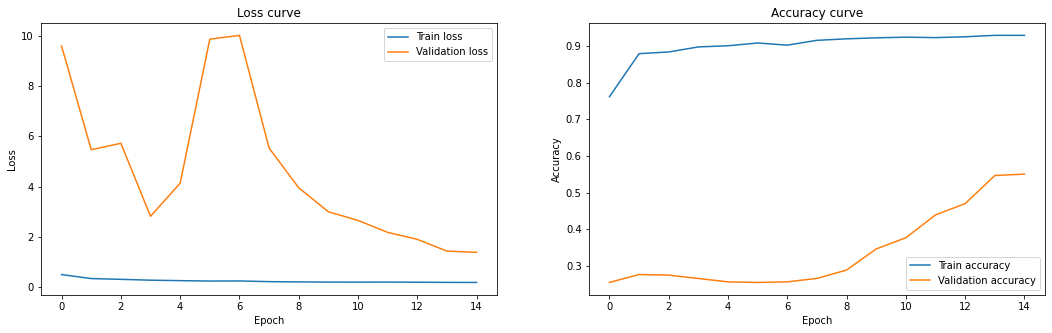

In [18]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(18, 5))
ax_loss.plot(history.epoch, history.history["loss"], label = "Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label = "Validation loss")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("Loss curve")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["accuracy"], label = "Train accuracy")
ax_acc.plot(history.epoch, history.history["val_accuracy"], label = "Validation accuracy")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("Accuracy curve")
ax_acc.legend()

Pokretanjem ovog dela koda se može proveriti preciznost modela, i ona iznosi ~64%.

In [19]:
result = model.evaluate(x_validation, y_validation)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy * 100:.2f}%")

25/25 [==============================] - 3s 92ms/step - loss: 1.3867 - accuracy: 0.5504
[+] Accuracy: 55.04%


# Validacija modela

Kreirani model se na kraju validira predikcijom nad validacionim skupom podataka.

Na početku je prikazan nasumični niz slika iz validacionog skupa, gde su crvenom bojom prikazane vrednosti iz maske koje predstavljaju mesta na kojima je zapravo nalazište soli, dok su zelenom bojom prikazane predikcije dobijene prethodnim modelom.

In [20]:
pred_validation = model.predict(x_validation)
pred_validation = pred_validation[:, :, :, 0]

print(x_validation.shape, y_validation.shape)

(800, 101, 101) (800, 101, 101)


In [21]:
def plotValidationImages(file1, file2, file3, k, alpha1, alpha2):
  fig, ax = plt.subplots(nrows = k, ncols = k, figsize=(15, 15))
  for i in range(k):
    for j in range(k):
      ind = randint(0, file1.shape[0] - 1)
      ax[i,j].imshow(file1[ind], cmap = 'Greys')
      ax[i,j].imshow(file2[ind], cmap = 'Reds', alpha = alpha1)
      ax[i,j].imshow(file3[ind], cmap = 'Greens', alpha = alpha2)
      ax[i,j].set_axis_off()
  fig.subplots_adjust(wspace = -0.30, hspace = 0.05)
  plt.suptitle("Crveno: So\nZeleno: Predikcija")

  return(fig)

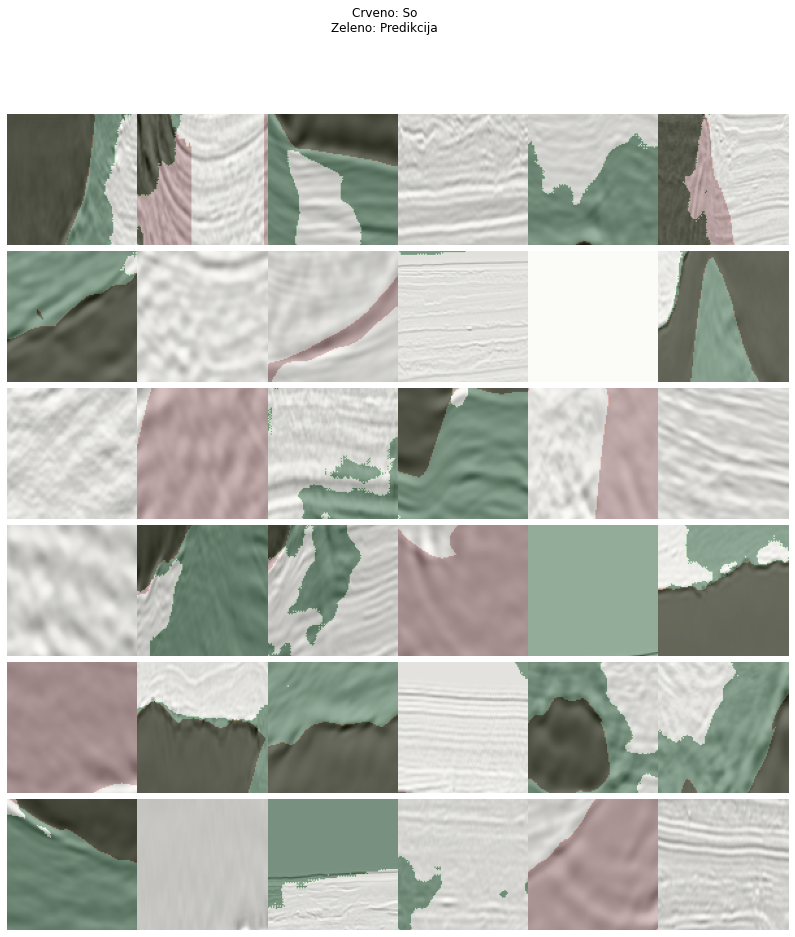

In [22]:
fig = plotValidationImages(x_validation, y_validation, np.round(pred_validation), k = 6, alpha1 = 0.4, alpha2 = 0.4)

Primenom IoU (_Intersection over union_) metrike, određena je tačnost određenog regiona dobijenog predikcijom naspram onog koji zapravo predstavlja region u kojem se nalazi so. 

Kako ova metrika prikazuje odnos preseka i unije dva regiona koja se porede, što je vrednost ove metrike bliža 1, predikcija je tačnija.

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table = False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0, 0.5, 1], [0, 0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0, 0.5, 1])[0]
    area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection
      
    # Exclude the background from analysis
    intersection = intersection[1:, 1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:, 1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis = 1) == 1   
        false_positives = np.sum(matches, axis = 0) == 0 
        false_negatives = np.sum(matches, axis = 1) == 0  
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
        
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_validation, np.int8(pred_validation > threshold)) for threshold in thresholds])

print(ious)

[0.209    0.20975  0.21525  0.216375 0.21775  0.222    0.226375 0.226625
 0.227375 0.22925  0.234125 0.237125 0.239625 0.2425   0.246    0.24675
 0.249125 0.2505   0.251625 0.25425  0.257625 0.258125 0.26325  0.265125
 0.265625 0.27025  0.271375 0.273125 0.27475  0.276375 0.27825 ]


In [25]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print("threshold best", threshold_best)
print("iou best", iou_best)

threshold best 0.7
iou best 0.27825


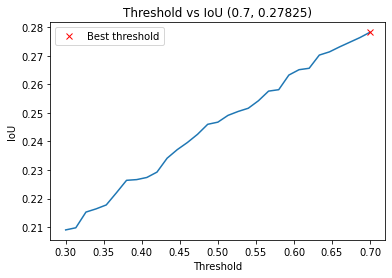

In [26]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label = "Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

Na kraju, nakon određene IoU metrike, prikazuje se rezultat predikcije nad validacionim skupom podataka.

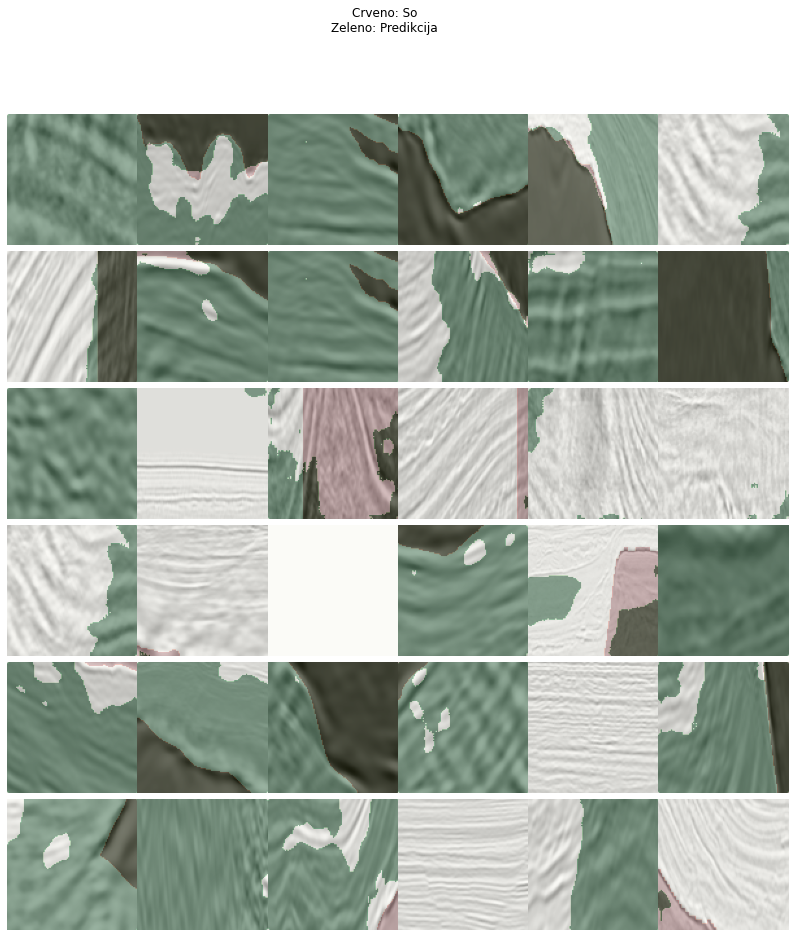

In [27]:
fig = plotValidationImages(x_validation, y_validation, np.int32(pred_validation > threshold_best), k = 6, alpha1 = 0.4, alpha2 = 0.4)